# NumPy/xarray Fundamentals: Shapes, Dtypes, and Chunking

In medical data integration, we often work with multi-dimensional datasets such as medical images, time series from monitoring devices, or genomic data. Understanding how to efficiently handle array shapes, data types, and memory management through chunking is crucial for processing large medical datasets.

This notebook will cover:
- Array shapes and dimensions in medical contexts
- Data types and their impact on memory usage
- Chunking strategies for large datasets
- Practical examples with medical data scenarios

Let's start by importing the necessary libraries and setting up our environment.

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
print(f"NumPy version: {np.__version__}")
print(f"xarray version: {xr.__version__}")

NumPy version: 2.2.6
xarray version: 2025.7.1


## Understanding Array Shapes in Medical Data

Medical data comes in various shapes and dimensions. Let's create some example datasets that represent common medical data structures.

In [2]:
# 1D: Patient vital signs over time (e.g., heart rate measurements)
heart_rate_1d = np.random.normal(75, 10, 100)  # 100 measurements
print(f"Heart rate data shape: {heart_rate_1d.shape}")
print(f"Dimensions: {heart_rate_1d.ndim}")

Heart rate data shape: (100,)
Dimensions: 1


Now let's create a 2D array representing multiple patients' vital signs measurements.

In [3]:
# 2D: Multiple patients, multiple time points
vital_signs_2d = np.random.normal(75, 10, (50, 100))  # 50 patients, 100 time points
print(f"Multiple patients vital signs shape: {vital_signs_2d.shape}")
print(f"Number of patients: {vital_signs_2d.shape[0]}")
print(f"Time points per patient: {vital_signs_2d.shape[1]}")

Multiple patients vital signs shape: (50, 100)
Number of patients: 50
Time points per patient: 100


Medical imaging data typically comes in 3D (single image with depth) or 4D (time series of 3D images). Let's simulate a simple medical image.

In [4]:
# 3D: Medical image (e.g., CT scan slice stack)
ct_scan_3d = np.random.randint(0, 255, (64, 64, 30))  # 64x64 pixels, 30 slices
print(f"CT scan shape: {ct_scan_3d.shape}")
print(f"Image dimensions (width x height): {ct_scan_3d.shape[0]} x {ct_scan_3d.shape[1]}")
print(f"Number of slices: {ct_scan_3d.shape[2]}")

CT scan shape: (64, 64, 30)
Image dimensions (width x height): 64 x 64
Number of slices: 30


## Data Types (dtypes) and Memory Efficiency

Choosing the right data type is crucial for memory efficiency, especially with large medical datasets. Let's explore how different dtypes affect memory usage.

In [5]:
# Create the same data with different dtypes
data_size = (1000, 1000)
image_float64 = np.random.rand(*data_size).astype(np.float64)
image_float32 = np.random.rand(*data_size).astype(np.float32)
image_uint8 = (np.random.rand(*data_size) * 255).astype(np.uint8)

print(f"float64 memory usage: {image_float64.nbytes / 1024**2:.2f} MB")
print(f"float32 memory usage: {image_float32.nbytes / 1024**2:.2f} MB")
print(f"uint8 memory usage: {image_uint8.nbytes / 1024**2:.2f} MB")

float64 memory usage: 7.63 MB
float32 memory usage: 3.81 MB
uint8 memory usage: 0.95 MB


Let's examine the precision and range differences between these data types.

In [6]:
# Examine dtype properties
dtypes_info = [np.float64, np.float32, np.uint8, np.int16]

for dtype in dtypes_info:
    info = np.iinfo(dtype) if np.issubdtype(dtype, np.integer) else np.finfo(dtype)
    print(f"{dtype.__name__}:")
    if hasattr(info, 'min') and hasattr(info, 'max'):
        print(f"  Range: {info.min} to {info.max}")
    if hasattr(info, 'eps'):
        print(f"  Machine epsilon: {info.eps}")
    print()

float64:
  Range: -1.7976931348623157e+308 to 1.7976931348623157e+308
  Machine epsilon: 2.220446049250313e-16

float32:
  Range: -3.4028234663852886e+38 to 3.4028234663852886e+38
  Machine epsilon: 1.1920928955078125e-07

uint8:
  Range: 0 to 255

int16:
  Range: -32768 to 32767



## Introduction to xarray

xarray provides labeled, multi-dimensional arrays that are perfect for medical data with meaningful dimension names and coordinates.

In [7]:
# Create time coordinates for patient monitoring data
time_coords = pd.date_range('2024-01-01 08:00', periods=24, freq='H')
patient_ids = [f'P{i:03d}' for i in range(1, 11)]  # 10 patients
vital_types = ['heart_rate', 'blood_pressure_sys', 'blood_pressure_dia', 'temperature']

# Create sample vital signs data
data = np.random.normal(loc=[75, 120, 80, 98.6], scale=[10, 15, 10, 1], 
                       size=(len(patient_ids), len(time_coords), len(vital_types)))

print(f"Data shape: {data.shape}")

Data shape: (10, 24, 4)


C:\Users\rober\AppData\Local\Temp\ipykernel_22572\2789027682.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_coords = pd.date_range('2024-01-01 08:00', periods=24, freq='H')


Now let's create an xarray DataArray with meaningful dimension names and coordinates.

In [8]:
# Create xarray DataArray
vital_signs_xr = xr.DataArray(
    data,
    dims=['patient', 'time', 'vital_type'],
    coords={
        'patient': patient_ids,
        'time': time_coords,
        'vital_type': vital_types
    },
    name='vital_signs'
)

print(vital_signs_xr)

<xarray.DataArray 'vital_signs' (patient: 10, time: 24, vital_type: 4)> Size: 8kB
array([[[ 65.13005412, 100.68613399,  76.38402051,  98.2139103 ],
        [103.46033082, 155.3279092 ,  83.36323077, 100.00836035],
        [ 90.17108849, 103.89485418,  65.6699318 ,  97.99232973],
        [ 70.59234376,  83.97357945,  64.77346437, 100.25435824],
        [ 70.19369761, 101.37599968,  66.8500545 ,  99.08535757],
        [ 77.62198578, 126.60289334,  85.49730462,  97.65338309],
        [ 66.0487098 , 131.4204592 ,  67.15304143,  97.85763074],
        [ 64.5659672 , 140.07519774,  89.48429789, 101.81074396],
        [ 69.18078888, 130.39977168,  92.97952885,  98.99250613],
        [ 75.96186602, 125.56733997,  83.93556917,  97.6790142 ],
        [ 73.46839435, 107.97176572,  76.37854963,  99.67875809],
        [ 67.3305197 , 106.97513726,  69.75599978,  96.53914534],
        [ 61.28614047, 106.78561256,  74.64813157,  98.8676496 ],
        [ 68.49015551, 115.35682985,  80.53143268,  98.52155

Let's explore the powerful indexing capabilities of xarray using labels instead of numerical indices.

In [9]:
# Select specific patient's heart rate data
patient_001_hr = vital_signs_xr.sel(patient='P001', vital_type='heart_rate')
print("Patient P001 heart rate over time:")
print(patient_001_hr)
print(f"Shape: {patient_001_hr.shape}")

Patient P001 heart rate over time:
<xarray.DataArray 'vital_signs' (time: 24)> Size: 192B
array([ 65.13005412, 103.46033082,  90.17108849,  70.59234376,
        70.19369761,  77.62198578,  66.0487098 ,  64.5659672 ,
        69.18078888,  75.96186602,  73.46839435,  67.3305197 ,
        61.28614047,  68.49015551,  78.34968443,  89.15602599,
        80.80684659,  69.82282984,  62.80237143,  74.74485297,
        90.07606622,  78.88430177,  87.01146857,  83.51381339])
Coordinates:
    patient     <U4 16B 'P001'
  * time        (time) datetime64[ns] 192B 2024-01-01T08:00:00 ... 2024-01-02...
    vital_type  <U18 72B 'heart_rate'
Shape: (24,)


We can also select data for specific time ranges, which is very useful for medical data analysis.

In [10]:
# Select data for a specific time range (morning hours)
morning_data = vital_signs_xr.sel(time=slice('2024-01-01 08:00', '2024-01-01 12:00'))
print("Morning vital signs data:")
print(f"Time range: {morning_data.time.values[0]} to {morning_data.time.values[-1]}")
print(f"Shape: {morning_data.shape}")

Morning vital signs data:
Time range: 2024-01-01T08:00:00.000000000 to 2024-01-01T12:00:00.000000000
Shape: (10, 5, 4)


## Understanding Chunking with Dask

For large medical datasets that don't fit in memory, we can use chunking. Let's create a larger dataset and demonstrate chunking strategies.

In [11]:
# Create a large simulated dataset (e.g., high-frequency ECG data)
# Simulate 100 patients, 24 hours of data, sampled at 1000 Hz
n_patients = 100
n_hours = 24
sampling_rate = 1000  # Hz
n_timepoints = n_hours * 3600 * sampling_rate  # Total samples

print(f"Dataset dimensions: {n_patients} patients × {n_timepoints:,} timepoints")
print(f"Estimated memory usage (float32): {(n_patients * n_timepoints * 4) / 1024**3:.2f} GB")

Dataset dimensions: 100 patients × 86,400,000 timepoints
Estimated memory usage (float32): 32.19 GB


Instead of creating this large array in memory, let's use dask to create a chunked array that can be processed efficiently.

In [12]:
import dask.array as da

# Create chunked array - each chunk represents 1 patient, 1 hour of data
chunk_size = (1, 3600 * sampling_rate)  # 1 patient, 1 hour of data per chunk
large_ecg_data = da.random.normal(0, 1, size=(n_patients, n_timepoints), 
                                 chunks=chunk_size)

print(f"Chunked array shape: {large_ecg_data.shape}")
print(f"Chunk size: {large_ecg_data.chunks}")
print(f"Number of chunks: {large_ecg_data.npartitions}")

Chunked array shape: (100, 86400000)
Chunk size: ((1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1), (3600000, 3600000, 3600000, 3600000, 3600000, 3600000, 3600000, 3600000, 3600000, 3600000, 3600000, 3600000, 3600000, 3600000, 3600000, 3600000, 3600000, 3600000, 3600000, 3600000, 3600000, 3600000, 3600000, 3600000))
Number of chunks: 2400


Let's create an xarray Dataset with chunked data and see how it handles large datasets efficiently.

In [13]:
# Create time coordinates (this would be huge, so let's use a smaller example)
# For demonstration, let's use a smaller dataset
small_n_timepoints = 3600 * 2  # 2 hours instead of 24
small_ecg_data = da.random.normal(0, 1, size=(10, small_n_timepoints), 
                                 chunks=(1, 3600))

# Create xarray with chunked data
time_coords_small = pd.date_range('2024-01-01', periods=small_n_timepoints, freq='S')
patient_coords = [f'P{i:03d}' for i in range(1, 11)]

ecg_xr = xr.DataArray(
    small_ecg_data,
    dims=['patient', 'time'],
    coords={
        'patient': patient_coords,
        'time': time_coords_small
    },
    name='ecg_signal'
)

print(ecg_xr)

<xarray.DataArray 'ecg_signal' (patient: 10, time: 7200)> Size: 576kB
dask.array<normal, shape=(10, 7200), dtype=float64, chunksize=(1, 3600), chunktype=numpy.ndarray>
Coordinates:
  * patient  (patient) <U4 160B 'P001' 'P002' 'P003' ... 'P008' 'P009' 'P010'
  * time     (time) datetime64[ns] 58kB 2024-01-01 ... 2024-01-01T01:59:59


C:\Users\rober\AppData\Local\Temp\ipykernel_22572\976265983.py:8: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time_coords_small = pd.date_range('2024-01-01', periods=small_n_timepoints, freq='S')


Let's perform some operations on the chunked data to see how xarray handles computation lazily.

In [14]:
# Compute statistics - these operations are lazy until we call .compute()
mean_ecg = ecg_xr.mean(dim='time')
std_ecg = ecg_xr.std(dim='time')

print("Mean ECG per patient (lazy computation):")
print(mean_ecg)
print("\nActual computed values:")
print(mean_ecg.compute())

Mean ECG per patient (lazy computation):
<xarray.DataArray 'ecg_signal' (patient: 10)> Size: 80B
dask.array<mean_agg-aggregate, shape=(10,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * patient  (patient) <U4 160B 'P001' 'P002' 'P003' ... 'P008' 'P009' 'P010'

Actual computed values:
<xarray.DataArray 'ecg_signal' (patient: 10)> Size: 80B
array([-0.01216887,  0.0106882 ,  0.00050611,  0.00396435,  0.00277604,
       -0.0532844 , -0.00868342,  0.00792805, -0.0123627 ,  0.00043925])
Coordinates:
  * patient  (patient) <U4 160B 'P001' 'P002' 'P003' ... 'P008' 'P009' 'P010'


## Practical Example: Medical Image Analysis

Let's create a more realistic example with simulated medical imaging data.

In [15]:
# Simulate a 4D medical dataset: (patients, time_points, x, y)
# Example: fMRI data with multiple patients, time series, and 2D brain slices
n_subjects = 5
n_timepoints = 100
img_width, img_height = 64, 64

# Create chunked fMRI-like data
fmri_data = da.random.normal(1000, 100, 
                           size=(n_subjects, n_timepoints, img_width, img_height),
                           chunks=(1, 50, 32, 32))

print(f"fMRI data shape: {fmri_data.shape}")
print(f"Chunks: {fmri_data.chunks}")

fMRI data shape: (5, 100, 64, 64)
Chunks: ((1, 1, 1, 1, 1), (50, 50), (32, 32), (32, 32))


Now let's create a proper xarray Dataset with meaningful coordinates and multiple variables.

In [16]:
# Create coordinates
subjects = [f'S{i:02d}' for i in range(1, n_subjects + 1)]
timepoints = np.arange(0, n_timepoints * 2, 2)  # TR = 2 seconds
x_coords = np.arange(img_width)
y_coords = np.arange(img_height)

# Create xarray Dataset
fmri_dataset = xr.Dataset({
    'bold_signal': (['subject', 'time', 'x', 'y'], fmri_data),
    'subject_age': (['subject'], np.random.randint(20, 65, n_subjects)),
    'subject_group': (['subject'], np.random.choice(['control', 'patient'], n_subjects))
}, coords={
    'subject': subjects,
    'time': timepoints,
    'x': x_coords,
    'y': y_coords
})

print(fmri_dataset)

<xarray.Dataset> Size: 16MB
Dimensions:        (subject: 5, time: 100, x: 64, y: 64)
Coordinates:
  * subject        (subject) <U3 60B 'S01' 'S02' 'S03' 'S04' 'S05'
  * time           (time) int64 800B 0 2 4 6 8 10 12 ... 188 190 192 194 196 198
  * x              (x) int64 512B 0 1 2 3 4 5 6 7 8 ... 56 57 58 59 60 61 62 63
  * y              (y) int64 512B 0 1 2 3 4 5 6 7 8 ... 56 57 58 59 60 61 62 63
Data variables:
    bold_signal    (subject, time, x, y) float64 16MB dask.array<chunksize=(1, 50, 32, 32), meta=np.ndarray>
    subject_age    (subject) int32 20B 55 40 59 38 34
    subject_group  (subject) <U7 140B 'control' 'control' ... 'patient'


Let's perform some typical medical imaging analysis operations on this dataset.

In [17]:
# Calculate temporal mean for each voxel
temporal_mean = fmri_dataset['bold_signal'].mean(dim='time')
print("Temporal mean shape:", temporal_mean.shape)

# Calculate group averages
control_subjects = fmri_dataset.where(fmri_dataset.subject_group == 'control', drop=True)
patient_subjects = fmri_dataset.where(fmri_dataset.subject_group == 'patient', drop=True)

print(f"Control subjects: {len(control_subjects.subject)}")
print(f"Patient subjects: {len(patient_subjects.subject)}")

Temporal mean shape: (5, 64, 64)
Control subjects: 2
Patient subjects: 3


Finally, let's visualize some of our data to ensure everything looks reasonable.

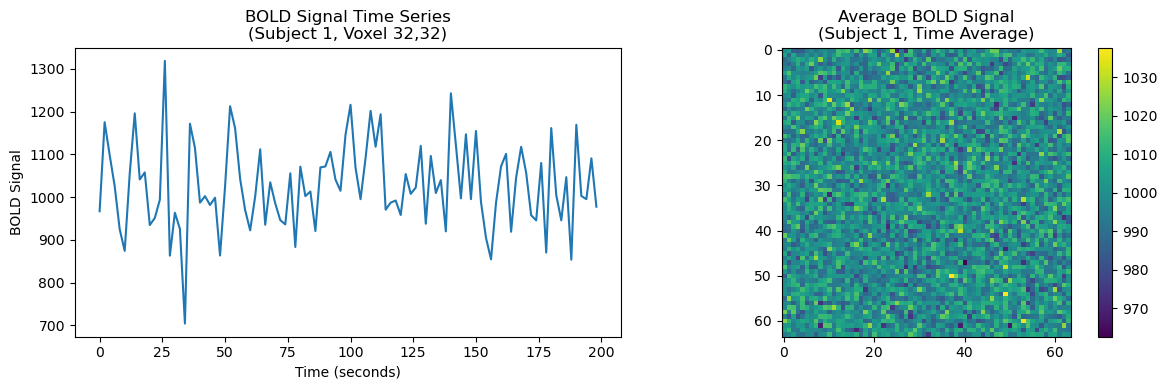

In [18]:
# Create a simple visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Time series for a single voxel
single_voxel_ts = fmri_dataset['bold_signal'].isel(subject=0, x=32, y=32).compute()
axes[0].plot(single_voxel_ts.time, single_voxel_ts.values)
axes[0].set_title('BOLD Signal Time Series\n(Subject 1, Voxel 32,32)')
axes[0].set_xlabel('Time (seconds)')
axes[0].set_ylabel('BOLD Signal')

# Plot 2: Spatial map (average over time)
spatial_avg = temporal_mean.isel(subject=0).compute()
im = axes[1].imshow(spatial_avg.values, cmap='viridis')
axes[1].set_title('Average BOLD Signal\n(Subject 1, Time Average)')
plt.colorbar(im, ax=axes[1])

plt.tight_layout()
plt.show()

## Exercise

Now it's time to apply what you've learned! Create a medical dataset analysis workflow using the concepts from this notebook.

**Task:** Create a simulated longitudinal patient monitoring dataset with the following specifications:

1. **Dataset structure:**
   - 20 patients (use patient IDs like 'PAT001', 'PAT002', etc.)
   - 7 days of monitoring data
   - 4 vital signs: heart rate, blood pressure (systolic), respiratory rate, oxygen saturation
   - Measurements taken every 15 minutes

2. **Data generation:**
   - Use appropriate realistic mean values and standard deviations for each vital sign
   - Choose an appropriate dtype to balance precision and memory usage
   - Add some random patient metadata (age, gender, diagnosis)

3. **Analysis tasks:**
   - Calculate daily averages for each patient and vital sign
   - Find patients with heart rate values outside the normal range (60-100 bpm)
   - Create a chunked version of your dataset with appropriate chunk sizes
   - Compare memory usage between different dtype choices

4. **Bonus:**
   - Create a simple visualization showing the trend of one vital sign over the week for 3 different patients
   - Calculate correlation between different vital signs

Use both NumPy and xarray in your solution, and demonstrate the advantages of using labeled dimensions with xarray for this type of medical data analysis.